### Importing Relevant Packages

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Loading and Transforming the Data

In [2]:
raw_csv_data = pd.read_csv("Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')



### Removing Surplus Data

In [3]:
df_comp['market_value']=df_comp.spx

In [4]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

### White Noise

In [5]:
wn = np.random.normal(loc = df.market_value.mean(), scale = df.market_value.std(), size = len(df))

In [6]:
df['wn'] = wn

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
df.describe()

,market_value,wn
count,5021.000000,5021.000000
mean,1091.651926,1086.024266
std,292.559287,293.625256
min,438.920000,-75.133957
25%,914.620000,886.106199
50%,1144.650000,1082.253159
75%,1316.280729,1288.154894
max,1570.252238,2217.224243


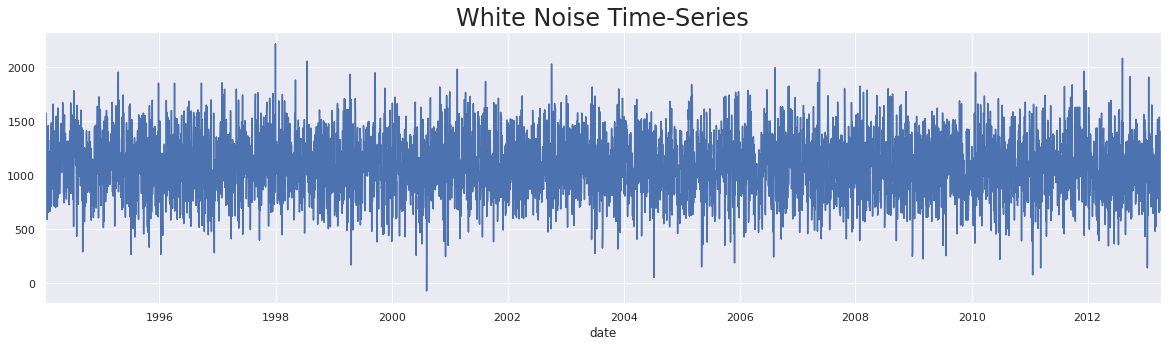

In [8]:
df.wn.plot(figsize = (20,5))
plt.title("White Noise Time-Series", size= 24)
plt.show()

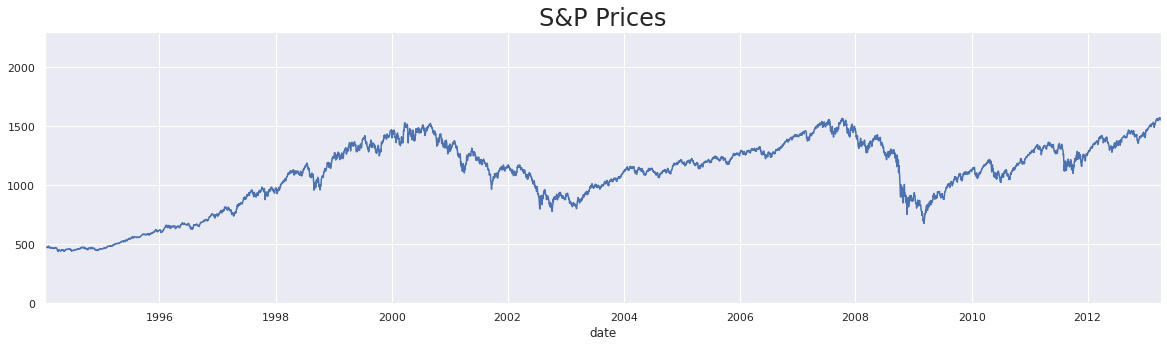

In [9]:
df.market_value.plot(figsize=(20,5))
plt.title("S&P Prices", size = 24)
plt.ylim(0,2300)
plt.show()

### Random Walk

In [10]:
rw = pd.read_csv("RandWalk.csv")
rw.date = pd.to_datetime(rw.date, dayfirst = True)
rw.set_index("date", inplace = True)
rw = rw.asfreq('b')

In [11]:
rw.describe()

,price
count,5021.000000
mean,1269.944293
std,444.216793
min,585.483034
25%,931.550429
50%,1156.363045
75%,1488.362029
max,2715.508720


In [12]:
df['rw'] = rw.price
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,market_value,wn,rw
date,,,
1994-01-07,469.90,934.299100,1122.139662
1994-01-10,475.27,1499.238209,1080.347860
1994-01-11,474.13,1056.176959,1082.095245
1994-01-12,474.17,964.580523,1083.639265
1994-01-13,472.47,1191.294955,1067.146255


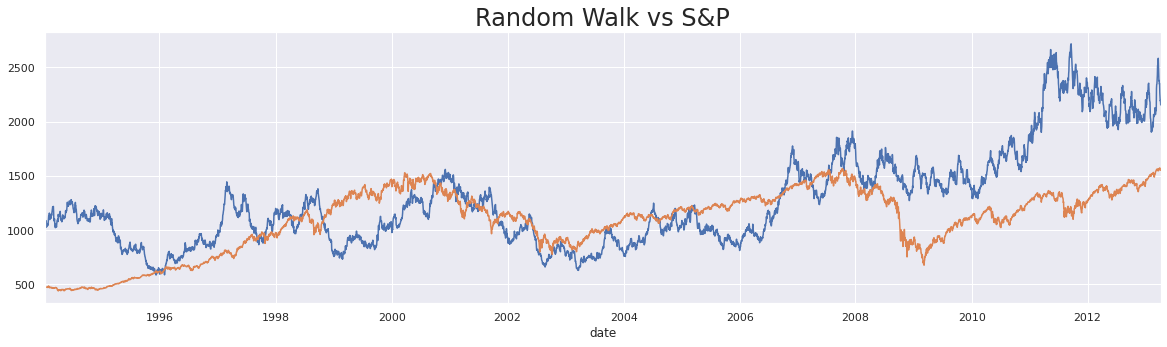

In [13]:
df.rw.plot(figsize = (20,5))
df.market_value.plot()
plt.title("Random Walk vs S&P", size = 24)
plt.show()

### Stationarity

In [14]:
sts.adfuller(df.market_value)

(-1.7369847452352454,
 0.4121645696770613,
 18,
 5002,
 {'1%': -3.431658008603046,
  '10%': -2.567077669247375,
  '5%': -2.862117998412982},
 39904.880607487445)

In [15]:
sts.adfuller(df.wn)

(-70.43163607873882,
 0.0,
 0,
 5020,
 {'1%': -3.431653316130827,
  '10%': -2.5670765656497516,
  '5%': -2.8621159253018247},
 70851.9327710865)

In [16]:
sts.adfuller(df.rw)

(-1.3286073927689719,
 0.6159849181617385,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '10%': -2.567078038881065,
  '5%': -2.8621186927706463},
 46299.333497595144)

### Seasonality

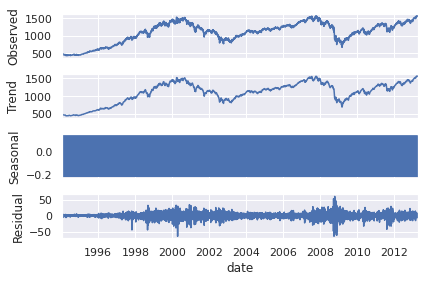

In [17]:
s_dec_additive = seasonal_decompose(df.market_value, model = "additive")
s_dec_additive.plot()
plt.show()

no concrete cyclical pattern in using naive decomposition as seasonal is not clear. No seasonality. 
Also the trend closely resembles the observed time series. The trend follows the observed data closely

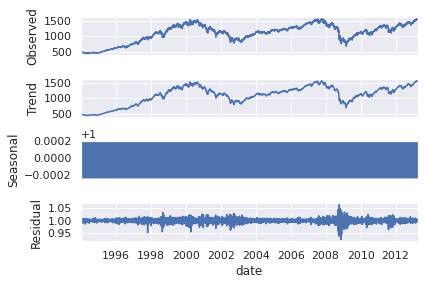

In [18]:
s_dec_multiplicative = seasonal_decompose(df.market_value, model = "multiplicative")
s_dec_multiplicative.plot()
plt.show()

No seasonality among snp prices

### ACF

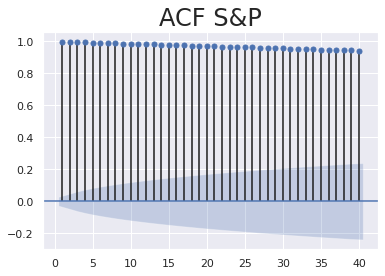

In [19]:
#it is common to use 40 lags in time series, 40 lags mean 40 periods before the current one
#zero = false , because we do not need the current value, ACF=1
sgt.plot_acf(df.market_value, lags = 40, zero = False)
plt.title("ACF S&P", size = 24)
plt.show()

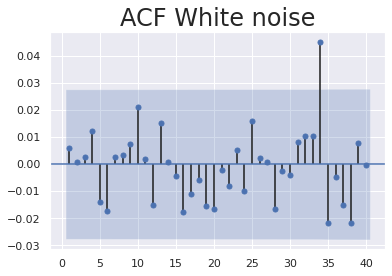

In [20]:
sgt.plot_acf(df.wn, lags = 40, zero = False)
plt.title("ACF White noise", size = 24)
plt.show()
#we have positive and negative autocorrelation, blue area is the area of significance, 
#if peaks are in the blue area then they are not significant,
#there is no autocorrelation for each lag

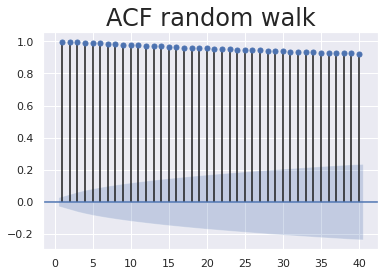

In [21]:
sgt.plot_acf(df.rw, lags = 40, zero = False)
plt.title("ACF random walk", size = 24)
plt.show()

### PACF

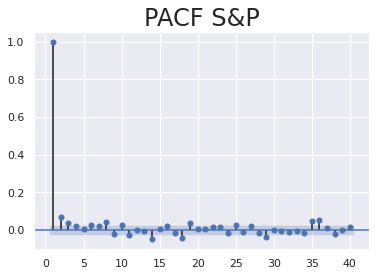

In [22]:
sgt.plot_pacf(df.market_value, lags = 40, zero = False, method = ('ols'))
plt.title("PACF S&P", size = 24)
plt.show()
#only a few elements are significantly different from zero

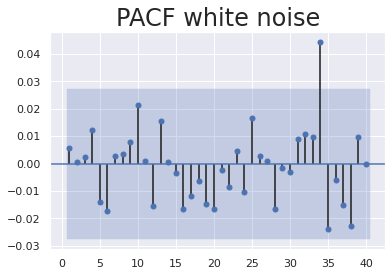

In [23]:
sgt.plot_pacf(df.wn, lags = 40, zero = False, method = ('ols'))
plt.title("PACF white noise", size = 24)
plt.show()

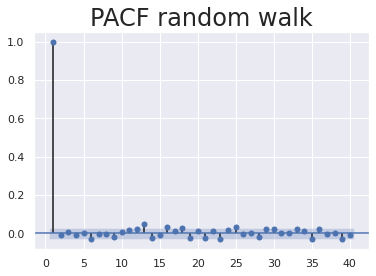

In [24]:
sgt.plot_pacf(df.rw, lags = 40, zero = False, method = ('ols'))
plt.title("PACF random walk", size = 24)
plt.show()